In [3]:
import tensorflow as tf
import tensorflow_datasets as tfds
from datasetB_main import MyDataset
import numpy as np
import matplotlib.pyplot as plt
import tempfile

In [4]:
import shutil
shutil.rmtree('./tmp')
tmp_dir = tempfile.mkdtemp()

builder = MyDataset(data_dir='tmp')
builder.download_and_prepare(
	download_dir='tmp',
	download_config=tfds.download.DownloadConfig(manual_dir='tmp')
)
dataset_train_raw = builder.as_dataset(split='train')
dataset_test_raw = builder.as_dataset(split='test')
dataset_val_raw = builder.as_dataset(split='val')
dataset_info = builder.info

print(dataset_info)

Dataset my_dataset downloaded and prepared to tmp/my_dataset/1.0.0. Subsequent calls will reuse this data.
tfds.core.DatasetInfo(
    name='my_dataset',
    full_name='my_dataset/1.0.0',
    description="""
    Dataset B pour le pierre papier ciseaux
    """,
    homepage='https://www.tensorflow.org/datasets/catalog/my_dataset',
    data_dir='tmp/my_dataset/1.0.0',
    file_format=tfrecord,
    download_size=Unknown size,
    dataset_size=91.77 MiB,
    features=FeaturesDict({
        'image': Image(shape=(300, 300, 3), dtype=uint8),
        'label': ClassLabel(shape=(), dtype=int64, num_classes=3),
    }),
    supervised_keys=('image', 'label'),
    disable_shuffling=False,
    splits={
        'test': <SplitInfo num_examples=720, num_shards=1>,
        'train': <SplitInfo num_examples=3360, num_shards=1>,
        'val': <SplitInfo num_examples=720, num_shards=1>,
    },
    citation="""""",
)


In [5]:
print('Raw train dataset:', dataset_train_raw)
print('Raw train dataset size:', len(dataset_train_raw), '\n')

print('Raw test dataset:', dataset_test_raw)
print('Raw test dataset size:', len(dataset_test_raw), '\n')

print('Raw val dataset:', dataset_val_raw)
print('Raw val dataset size:', len(dataset_val_raw), '\n')

Raw train dataset: <_PrefetchDataset element_spec={'image': TensorSpec(shape=(300, 300, 3), dtype=tf.uint8, name=None), 'label': TensorSpec(shape=(), dtype=tf.int64, name=None)}>
Raw train dataset size: 3360 

Raw test dataset: <_PrefetchDataset element_spec={'image': TensorSpec(shape=(300, 300, 3), dtype=tf.uint8, name=None), 'label': TensorSpec(shape=(), dtype=tf.int64, name=None)}>
Raw test dataset size: 720 

Raw val dataset: <_PrefetchDataset element_spec={'image': TensorSpec(shape=(300, 300, 3), dtype=tf.uint8, name=None), 'label': TensorSpec(shape=(), dtype=tf.int64, name=None)}>
Raw val dataset size: 720 



In [6]:
NUM_TRAIN_EXAMPLES = dataset_info.splits['train'].num_examples
NUM_TEST_EXAMPLES = dataset_info.splits['test'].num_examples
NUM_VAL_EXAMPLES = dataset_info.splits['val'].num_examples
NUM_CLASSES = dataset_info.features['label'].num_classes

print('Number of TRAIN examples:', NUM_TRAIN_EXAMPLES)
print('Number of TEST examples:', NUM_TEST_EXAMPLES)
print('Number of VAL examples:', NUM_VAL_EXAMPLES)
print('Number of label classes:', NUM_CLASSES)

Number of TRAIN examples: 3360
Number of TEST examples: 720
Number of VAL examples: 720
Number of label classes: 3


In [7]:
INPUT_IMG_SIZE_ORIGINAL = dataset_info.features['image'].shape[0]
INPUT_IMG_SHAPE_ORIGINAL = dataset_info.features['image'].shape

INPUT_IMG_SIZE_REDUCED = INPUT_IMG_SIZE_ORIGINAL // 2
INPUT_IMG_SHAPE_REDUCED = (
    INPUT_IMG_SIZE_REDUCED,
    INPUT_IMG_SIZE_REDUCED,
    INPUT_IMG_SHAPE_ORIGINAL[2]
)

# Here we may switch between bigger or smaller image sized that we will train our model on.
INPUT_IMG_SIZE = INPUT_IMG_SIZE_REDUCED
INPUT_IMG_SHAPE = INPUT_IMG_SHAPE_REDUCED

print('Input image size (original):', INPUT_IMG_SIZE_ORIGINAL)
print('Input image shape (original):', INPUT_IMG_SHAPE_ORIGINAL)
print('\n')
print('Input image size (reduced):', INPUT_IMG_SIZE_REDUCED)
print('Input image shape (reduced):', INPUT_IMG_SHAPE_REDUCED)
print('\n')
print('Input image size:', INPUT_IMG_SIZE)
print('Input image shape:', INPUT_IMG_SHAPE)

Input image size (original): 300
Input image shape (original): (300, 300, 3)


Input image size (reduced): 150
Input image shape (reduced): (150, 150, 3)


Input image size: 150
Input image shape: (150, 150, 3)


In [8]:
# Function to convert label ID to labels string.
get_label_name = dataset_info.features['label'].int2str

In [9]:
print(get_label_name(0))
print(get_label_name(1))
print(get_label_name(2))

rock
paper
scissors


In [10]:
def preview_dataset(dataset):
    plt.figure(figsize=(12, 12))
    plot_index = 0
    for features in dataset.take(12):
        image = features['image']
        label = features['label']
        plot_index += 1
        plt.subplot(3, 4, plot_index)
        # plt.axis('Off')
        plt.title('Label: %s' % get_label_name(label.numpy()))
        plt.imshow(image.numpy())

2024-12-09 13:52:18.630247: I tensorflow/core/kernels/data/tf_record_dataset_op.cc:376] The default buffer size is 262144, which is overridden by the user specified `buffer_size` of 8388608
2024-12-09 13:52:18.674857: W tensorflow/core/kernels/data/cache_dataset_ops.cc:914] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.
2024-12-09 13:52:18.678677: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


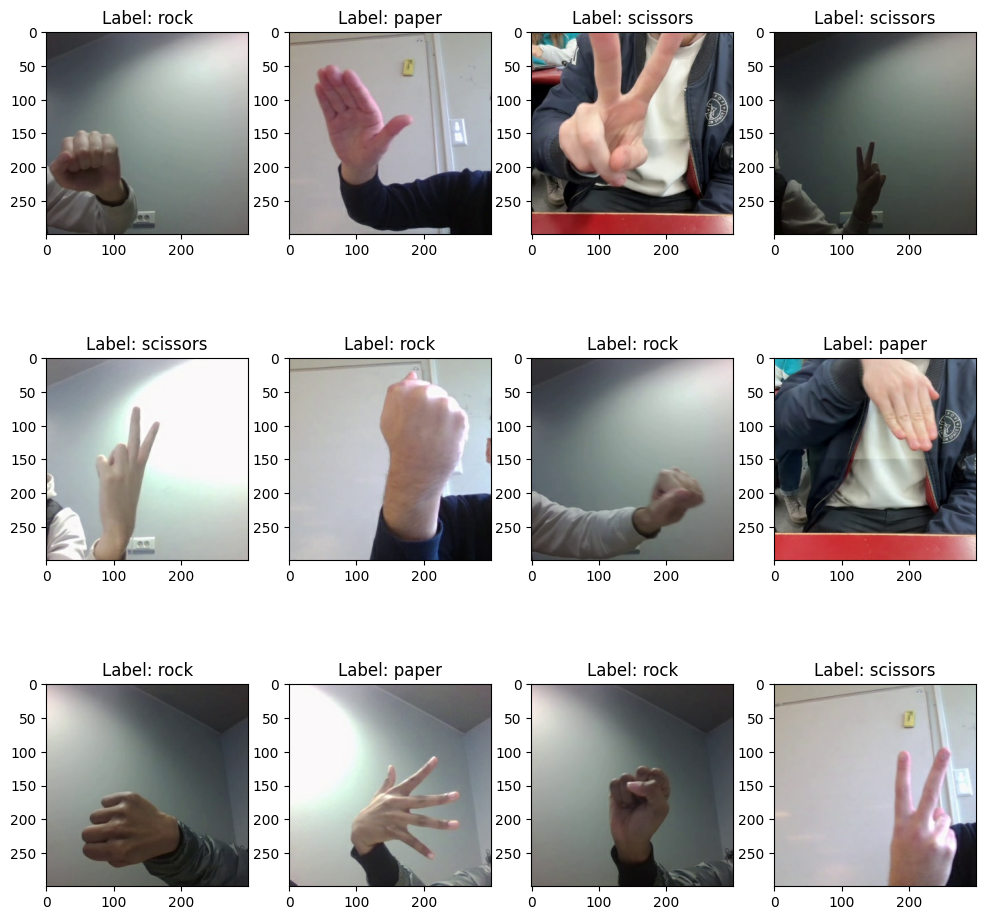

In [11]:
# Explore raw training dataset images.
preview_dataset(dataset_train_raw)

In [12]:
def format_example(features):
    image = features['image']
    label = features['label']
    # Make image color values to be float.
    image = tf.cast(image, tf.float32)
    # Make image color values to be in [0..1] range.
    image = image / 255.
    # Make sure that image has a right size
    image = tf.image.resize(image, [INPUT_IMG_SIZE, INPUT_IMG_SIZE])
    return image, label

In [13]:
print(dataset_train_raw)
dataset_train = dataset_train_raw.map(format_example)
dataset_test = dataset_test_raw.map(format_example)
dataset_val = dataset_val_raw.map(format_example)

<_PrefetchDataset element_spec={'image': TensorSpec(shape=(300, 300, 3), dtype=tf.uint8, name=None), 'label': TensorSpec(shape=(), dtype=tf.int64, name=None)}>


Label: 0 

Image shape: (150, 150, 3) 

[[[0.20784314 0.20392157 0.19607843]
  [0.20686275 0.19901961 0.20294118]
  [0.20588236 0.19803922 0.20196079]
  ...
  [0.83137256 0.7647059  0.79607844]
  [0.8372549  0.7705883  0.80980396]
  [0.84705883 0.76862746 0.8117647 ]]

 [[0.20882353 0.2009804  0.20490196]
  [0.20784314 0.2        0.20392157]
  [0.20784314 0.2        0.21176471]
  ...
  [0.8480392  0.78137255 0.8127451 ]
  [0.85294116 0.78627455 0.82549024]
  [0.8607843  0.7823529  0.82549024]]

 [[0.2127451  0.19313726 0.20882353]
  [0.21764706 0.19803922 0.21372549]
  [0.21764706 0.19803922 0.21372549]
  ...
  [0.8598039  0.7931373  0.82450986]
  [0.85882354 0.7921569  0.8235294 ]
  [0.87058824 0.7921569  0.827451  ]]

 ...

 [[0.05882353 0.05098039 0.07058824]
  [0.19117649 0.18333335 0.2029412 ]
  [0.28039217 0.2764706  0.29607844]
  ...
  [0.4117647  0.39607844 0.38431373]
  [0.4137255  0.39803922 0.38627452]
  [0.41274512 0.39705884 0.38529414]]

 [[0.06078432 0.04117647 0.0647058

2024-12-09 13:52:19.647255: W tensorflow/core/kernels/data/cache_dataset_ops.cc:914] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.
2024-12-09 13:52:19.647606: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


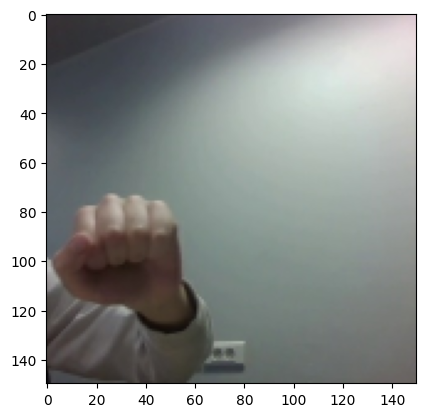

In [14]:
# Explore what values are used to represent the image.
(first_image, first_lable) = list(dataset_train.take(1))[0]
print('Label:', first_lable.numpy(), '\n')
print('Image shape:', first_image.numpy().shape, '\n')
print(first_image.numpy())
plt.imshow(first_image.numpy())

In [15]:
BATCH_SIZE = 32



dataset_test = dataset_test.batch(BATCH_SIZE)

dataset_val = dataset_val.batch(BATCH_SIZE)

In [16]:
#Load model
model = tf.keras.models.load_model('rock_paper_scissors_cnn.keras')

model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 148, 148, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 74, 74, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 72, 72, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 36, 36, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 34, 34, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 17, 17, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 15, 15, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 7, 7, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 6272)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 6272)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │     3,211,776 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 3)              │         1,539 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6,946,952 (26.50 MB)

 Trainable params: 3,473,475 (13.25 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 3,473,477 (13.25 MB)

In [17]:
# Test model with our dataset
model.evaluate(dataset_test)

23/23 ━━━━━━━━━━━━━━━━━━━━ 2s 86ms/step - accuracy: 0.3556 - loss: 6.0611


[5.768784523010254, 0.3499999940395355]

# Check Reproducitibility

2024-12-09 13:52:22.061526: W tensorflow/core/kernels/data/cache_dataset_ops.cc:914] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


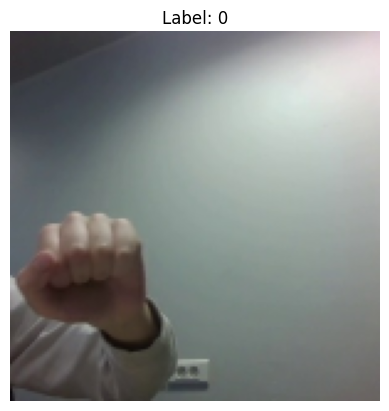

In [18]:
for image, label in dataset_train.take(1):  # Prenez le premier batch
    first_image = image.numpy()  # Select the first image from the batch
    first_label = label.numpy()  # Select the first label from the batch

    plt.imshow(first_image)
    plt.title(f"Label: {first_label}")
    plt.axis('off')
    plt.show()
    break

2024-12-09 13:52:22.171477: W tensorflow/core/kernels/data/cache_dataset_ops.cc:914] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


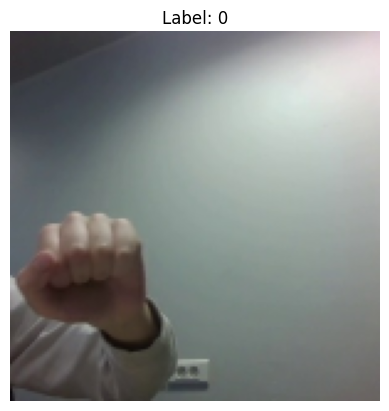

In [19]:
for image, label in dataset_train.take(1):  # Prenez le premier batch
    second_image = image.numpy()  # Select the first image from the batch
    second_label = label.numpy()  # Select the first label from the batch

    plt.imshow(second_image)
    plt.title(f"Label: {second_label}")
    plt.axis('off')
    plt.show()
    break

In [20]:
assert np.array_equal(second_image, first_image)
assert second_label == first_label
print('Reproducibility check passed.')

Reproducibility check passed.


# Random Method

In [21]:
def randomTrainDataset(percent):
    dataset_train_random = dataset_train.shuffle(
        buffer_size=NUM_TRAIN_EXAMPLES
    )

    dataset_train_random = dataset_train_random.batch(BATCH_SIZE)

    num_take = int(NUM_TRAIN_EXAMPLES * percent)

    dataset_train_random = dataset_train_random.take(
        count=num_take
    )

    steps_per_epoch = num_take // BATCH_SIZE

    return dataset_train_random, steps_per_epoch

def trainModel(epochs, percent):
    model = tf.keras.models.load_model('rock_paper_scissors_cnn.keras')
    dataset_train_random, steps_per_epoch = randomTrainDataset(percent)

    model.fit(
        dataset_train_random.repeat(),
        epochs=epochs,
        steps_per_epoch=steps_per_epoch,
        validation_data=dataset_val.repeat(),
        validation_steps=NUM_VAL_EXAMPLES // BATCH_SIZE
    )

    test_loss, test_accuracy = model.evaluate(dataset_test, verbose=1)
    print('Accuracy on test dataset:', test_accuracy)
    print('Loss on test dataset:', test_loss)

    return test_accuracy


# Random results

In [22]:
import scipy.stats as stats

percentages = [0.01, 0.02, 0.05, 0.1, 0.2]
nb_repeat = 5
random_average_accuracies = []
low_bound_confidence = []
high_bound_confidence = []

for percent in percentages:
    accuracies = []
    for i in range(nb_repeat):
        accuracy = trainModel(10, percent)
        accuracies.append(accuracy)
    average_accuracy = sum(accuracies) / len(accuracies)
    random_average_accuracies.append(average_accuracy)
    alpha = 1 - 0.95
    t_value = stats.t.ppf(1 - alpha / 2, df=nb_repeat-1)  # Valeur de t pour un niveau de confiance à 95%
    std_dev = np.std(accuracies)
    margin_of_error = t_value * (std_dev / np.sqrt(nb_repeat))
    min_confidence = average_accuracy - margin_of_error
    max_confidence = average_accuracy + margin_of_error
    low_bound_confidence.append(min_confidence)
    high_bound_confidence.append(max_confidence)
    
    


Epoch 1/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step - accuracy: 0.4062 - loss: 3.8907 - val_accuracy: 0.3977 - val_loss: 1.4672
Epoch 2/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 0.4062 - loss: 1.6720 - val_accuracy: 0.4332 - val_loss: 1.1191
Epoch 3/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 0.5000 - loss: 1.0647 - val_accuracy: 0.4403 - val_loss: 1.0636
Epoch 4/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 0.3750 - loss: 1.1152 - val_accuracy: 0.4489 - val_loss: 1.0673
Epoch 5/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 0.3125 - loss: 1.1335 - val_accuracy: 0.4361 - val_loss: 1.0371
Epoch 6/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 0.2812 - loss: 1.0925 - val_accuracy: 0.4418 - val_loss: 1.0168
Epoch 7/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 0.4688 - loss: 1.0269 - val_accuracy: 0.4446 - val_loss: 1.0189
Epoch 8/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 0.4062 - loss: 1.0554 - val_accuracy: 0.4545 - val_loss: 1.0492
Epoch 9/10
1/1 ━

# Random Graphs 

Average accuracies: [0.5344444453716278, 0.5944444537162781, 0.8202777743339539, 0.8283333420753479, 0.9877777814865112]
Low bound confidence: [0.4986770986160377, 0.5347746009376783, 0.7601155405299234, 0.6390125686252115, 0.975710986230171]
High bound confidence: [0.570211792127218, 0.6541143064948779, 0.8804400081379844, 1.0176541155254843, 0.9998445767428513]


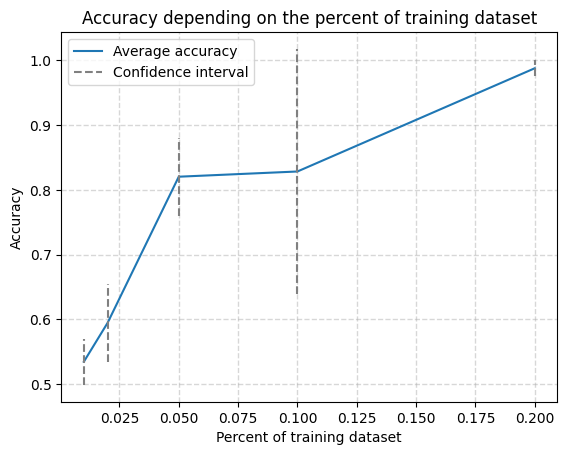

In [23]:
print("Average accuracies:", random_average_accuracies)
print("Low bound confidence:", low_bound_confidence)
print("High bound confidence:", high_bound_confidence)

plt.plot(percentages, random_average_accuracies, label='Average accuracy')
plt.vlines(percentages, low_bound_confidence, high_bound_confidence, color='grey', label='Confidence interval', linestyles='dashed')
plt.xlabel('Percent of training dataset')
plt.ylabel('Accuracy')
plt.title('Accuracy depending on the percent of training dataset')
plt.legend()
plt.grid(linestyle='--', linewidth=1, alpha=0.5)
plt.show()

# Least Confidense Method


In [24]:
import tensorflow as tf

import tensorflow as tf
import numpy as np

def get_least_confident_samples(model, percent, dataset):
    n = int(NUM_TRAIN_EXAMPLES * percent)
    uncertainty_dict = {}

    # Enumerate through the dataset
    for i, (features, labels) in enumerate(dataset):
        # Get predictions
        predictions = model(features, training=False)
        # Compute the max probability (confidence) for each sample in the batch
        confidences = tf.reduce_max(tf.nn.softmax(predictions, axis=-1), axis=-1).numpy()
        # Compute uncertainty scores (1 - confidence)
        uncertainty_scores = 1 - confidences
        
        # Store index, feature, label, and uncertainty score
        for j in range(features.shape[0]):  # Iterate through the batch
            uncertainty_dict[len(uncertainty_dict)] = (features[j], labels[j], uncertainty_scores[j])

    # Sort by uncertainty scores in descending order and take the top `n`
    sorted_uncertainty = sorted(uncertainty_dict.items(), key=lambda x: x[1][2], reverse=True)[:n]
    
    # Prepare the least confident samples as a list of tuples
    least_confident_samples = [(index, data[0], data[1], data[2]) for index, data in sorted_uncertainty]
    
    return least_confident_samples

def create_dataset_from_samples(least_confident_samples, batch_size):
    features = [sample[1] for sample in least_confident_samples]
    labels = [sample[2] for sample in least_confident_samples]
    dataset = tf.data.Dataset.from_tensor_slices((features, labels)).batch(batch_size)

    steps_per_epoch = len(least_confident_samples) // batch_size

    return dataset, steps_per_epoch


def train_least_confidence_dataset(epochs, percent):
    model = tf.keras.models.load_model('rock_paper_scissors_cnn.keras')  # Charger le modèle de base
    dataset_train_confidence = dataset_train.batch(BATCH_SIZE)  # Batch le dataset d'entraînement
    least_confidence_samples = get_least_confident_samples(model, percent, dataset_train_confidence)  # Obtenir les échantillons avec faible confiance
    least_confidence_dataset, steps_per_epoch = create_dataset_from_samples(least_confidence_samples, BATCH_SIZE)

    # Entraîner le modèle sur le dataset avec faible confiance
    model.fit(
        least_confidence_dataset.repeat(),
        epochs=epochs,
        steps_per_epoch=steps_per_epoch,
        validation_data=dataset_val.repeat(),
        validation_steps=NUM_VAL_EXAMPLES // BATCH_SIZE,
        verbose=1  # Afficher les progrès
    )

    # Évaluer le modèle
    test_loss, test_accuracy = model.evaluate(dataset_test, verbose=1)
    print(f"Accuracy on test dataset: {test_accuracy:.4f}")
    print(f"Loss on test dataset: {test_loss:.4f}")

    return test_accuracy



# Least Confidence Results

In [25]:
percentages = [0.01, 0.02, 0.05, 0.1, 0.2]

least_confidence_accuracies = []
for percent in percentages:
    print(f"\n=== Testing with {percent*100:.1f}% of the data ===")
    accuracy = train_least_confidence_dataset(10, percent)
    least_confidence_accuracies.append(accuracy)


=== Testing with 1.0% of the data ===
Epoch 1/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step - accuracy: 0.4062 - loss: 1.1976 - val_accuracy: 0.3665 - val_loss: 3.5703
Epoch 2/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step - accuracy: 0.0000e+00 - loss: 1.0354 - val_accuracy: 0.4034 - val_loss: 2.5236
Epoch 3/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step - accuracy: 0.7500 - loss: 0.9251 - val_accuracy: 0.3722 - val_loss: 3.6420
Epoch 4/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step - accuracy: 1.0000 - loss: 0.0604 - val_accuracy: 0.3594 - val_loss: 3.7099
Epoch 5/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step - accuracy: 0.7500 - loss: 0.5719 - val_accuracy: 0.4062 - val_loss: 2.7060
Epoch 6/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step - accuracy: 1.0000 - loss: 0.0351 - val_accuracy: 0.4077 - val_loss: 2.8135
Epoch 7/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step - accuracy: 0.8750 - loss: 0.2922 - val_accuracy: 0.4077 - val_loss: 4.0688
Epoch 8/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step - accuracy: 1.0000 - loss: 0.0399 - val_accuracy:

2024-12-09 14:17:01.940366: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


2/2 ━━━━━━━━━━━━━━━━━━━━ 4s 3s/step - accuracy: 0.3854 - loss: 1.1796 - val_accuracy: 0.4134 - val_loss: 2.7168
Epoch 2/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step - accuracy: 0.6032 - loss: 0.7197 - val_accuracy: 0.4190 - val_loss: 2.2811
Epoch 3/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step - accuracy: 0.7937 - loss: 0.6608 - val_accuracy: 0.4190 - val_loss: 2.9789
Epoch 4/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 4s 3s/step - accuracy: 0.8958 - loss: 0.3239 - val_accuracy: 0.4219 - val_loss: 2.7336
Epoch 5/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step - accuracy: 1.0000 - loss: 0.1284 - val_accuracy: 0.4162 - val_loss: 3.4213
Epoch 6/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step - accuracy: 0.9411 - loss: 0.1708 - val_accuracy: 0.4190 - val_loss: 3.5446
Epoch 7/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step - accuracy: 0.9792 - loss: 0.0890 - val_accuracy: 0.4247 - val_loss: 3.9019
Epoch 8/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step - accuracy: 1.0000 - loss: 0.0258 - val_accuracy: 0.4347 - val_loss: 4.0511
Epoch 9/10
2/2 ━━━━━━━━━━━━

# Least Confidence Graphs

Accuracies: [0.42500001192092896, 0.45277777314186096, 0.5097222328186035, 0.5652777552604675, 0.6888889074325562]


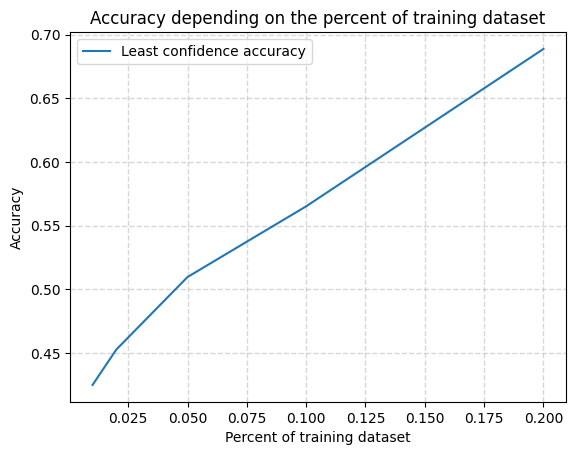

In [26]:
print("Accuracies:", least_confidence_accuracies)

plt.plot(percentages, least_confidence_accuracies, label='Least confidence accuracy')
plt.xlabel('Percent of training dataset')
plt.ylabel('Accuracy')
plt.title('Accuracy depending on the percent of training dataset')
plt.legend()
plt.grid(linestyle='--', linewidth=1, alpha=0.5)
plt.show()

# Diversity Method

## Model-based outlier methods

In [31]:
def get_outlier_samples(model, percent, dataset):
    n = int(NUM_TRAIN_EXAMPLES * percent)
    margin_dict = {}

    for i, (features, labels) in enumerate(dataset):
        predictions = model(features, training=False)
        top_2_probs = tf.math.top_k(tf.nn.softmax(predictions, axis=-1), k=2).values.numpy()
        margins = top_2_probs[:, 0] - top_2_probs[:, 1]
        
        for j in range(features.shape[0]):  # Iterate through the batch
            margin_dict[len(margin_dict)] = (features[j], labels[j], margins[j])

    sorted_margins = sorted(margin_dict.items(), key=lambda x: x[1][2], reverse=True)[:n]
    
    margin_samples = [(index, data[0], data[1], data[2]) for index, data in sorted_margins]
    
    return margin_samples

def create_dataset_from_outlier_samples(margin_samples, batch_size):
    features = [sample[1] for sample in margin_samples]
    labels = [sample[2] for sample in margin_samples]
    dataset = tf.data.Dataset.from_tensor_slices((features, labels)).batch(batch_size)

    steps_per_epoch = len(margin_samples) // batch_size

    return dataset, steps_per_epoch

def train_outlier_dataset(epochs, percent):
    model = tf.keras.models.load_model('rock_paper_scissors_cnn.keras')  # Charger le modèle de base
    dataset_train_margin = dataset_train.batch(BATCH_SIZE)  # Batch le dataset d'entraînement
    margin_samples = get_outlier_samples(model, percent, dataset_train_margin)  # Obtenir les échantillons avec faible confiance
    margin_dataset, steps_per_epoch = create_dataset_from_outlier_samples(margin_samples, BATCH_SIZE)

    model.fit(
        margin_dataset.repeat(),
        epochs=epochs,
        steps_per_epoch=steps_per_epoch,
        validation_data=dataset_val.repeat(),
        validation_steps=NUM_VAL_EXAMPLES // BATCH_SIZE,
        verbose=1  # Afficher les progrès
    )

    # Évaluer le modèle
    test_loss, test_accuracy = model.evaluate(dataset_test, verbose=1)
    print(f"Accuracy on test dataset: {test_accuracy:.4f}")
    print(f"Loss on test dataset: {test_loss:.4f}")

    return test_accuracy

## Model-based outlier results

In [32]:
percentages = [0.01, 0.02, 0.05, 0.1, 0.2]

outlier_accuracies = []
for percent in percentages:
    print(f"\n=== Testing with {percent*100:.1f}% of the data ===")
    accuracy = train_outlier_dataset(10, percent)
    outlier_accuracies.append(accuracy)


=== Testing with 1.0% of the data ===
Epoch 1/10


2024-12-09 14:25:49.340597: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step - accuracy: 0.3438 - loss: 19.8596 - val_accuracy: 0.3409 - val_loss: 1.3168
Epoch 2/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 0.0000e+00 - loss: 1.0657 - val_accuracy: 0.3679 - val_loss: 1.1792
Epoch 3/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 0.5938 - loss: 0.8600 - val_accuracy: 0.3864 - val_loss: 1.1430
Epoch 4/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 1.0000 - loss: 0.3147 - val_accuracy: 0.3622 - val_loss: 1.2582
Epoch 5/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 0.6562 - loss: 0.7080 - val_accuracy: 0.3991 - val_loss: 1.1245
Epoch 6/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 1.0000 - loss: 0.1198 - val_accuracy: 0.3849 - val_loss: 1.1773
Epoch 7/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 0.7500 - loss: 0.4889 - val_accuracy: 0.4034 - val_loss: 1.1674
Epoch 8/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 1.0000 - loss: 0.0412 - val_accuracy: 0.3935 - val_loss: 1.2098
Epoch 9/10
1/1 ━━━━━━━

## Model-based outlier graphs

Acurracies : [0.39722222089767456, 0.44583332538604736, 0.4694444537162781, 0.5611110925674438, 0.6402778029441833]


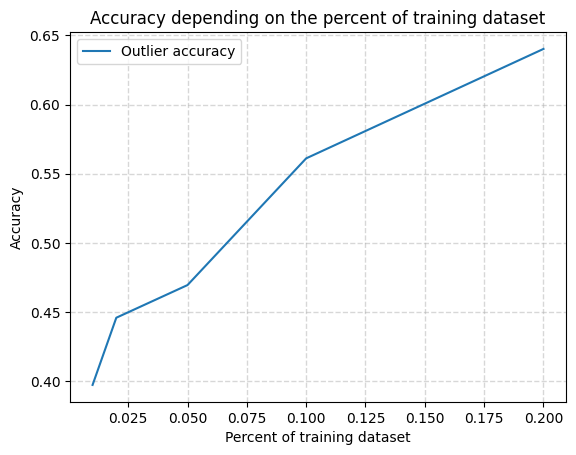

In [33]:
print("Acurracies :", outlier_accuracies)

plt.plot(percentages, outlier_accuracies, label='Outlier accuracy')
plt.xlabel('Percent of training dataset')
plt.ylabel('Accuracy')
plt.title('Accuracy depending on the percent of training dataset')
plt.legend()
plt.grid(linestyle='--', linewidth=1, alpha=0.5)
plt.show()

# Graphs Comparision

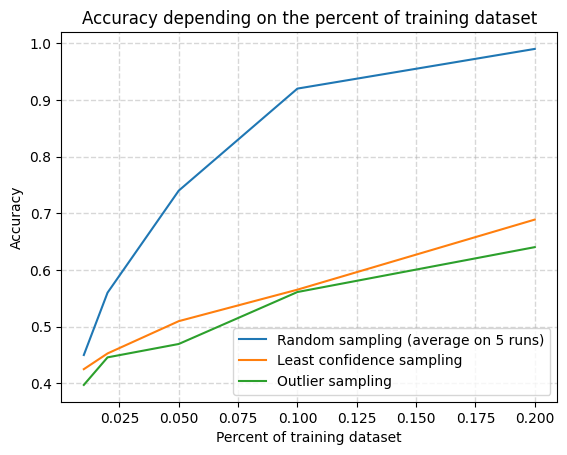

In [ ]:
# On a single graph, plot the accuracies of random and least confidence sampling methods

plt.plot(percentages, random_average_accuracies, label='Random sampling (average on 5 runs)')
plt.plot(percentages, least_confidence_accuracies, label='Least confidence sampling')
plt.plot(percentages, outlier_accuracies, label='Outlier sampling')
plt.xlabel('Percent of training dataset')
plt.ylabel('Accuracy')
plt.title('Accuracy depending on the percent of training dataset')
plt.legend()
plt.grid(linestyle='--', linewidth=1, alpha=0.5)
plt.show()